# Time Series Forecasting with Yahoo Stock Price

### Import Libraries

In [20]:
# 1. Import thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, GRU, Conv1D, MaxPooling1D
from keras.layers import Input, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'D:\BSKT_Cao học\2024_HK1\3.Khoa học dự đoán\python_DS\yahoo_stock.csv')


In [3]:
df.shape

(1825, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [5]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


### Exploratory Data Analysis (EDA)

In [6]:
df.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [7]:
# Chuyển đổi cột Date thành datetime
df['Date'] = pd.to_datetime(df['Date'])
# Đặt Date làm index
df.set_index('Date', inplace=True)
df.sort_index(inplace = True)

In [8]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


##### Time series Visualization

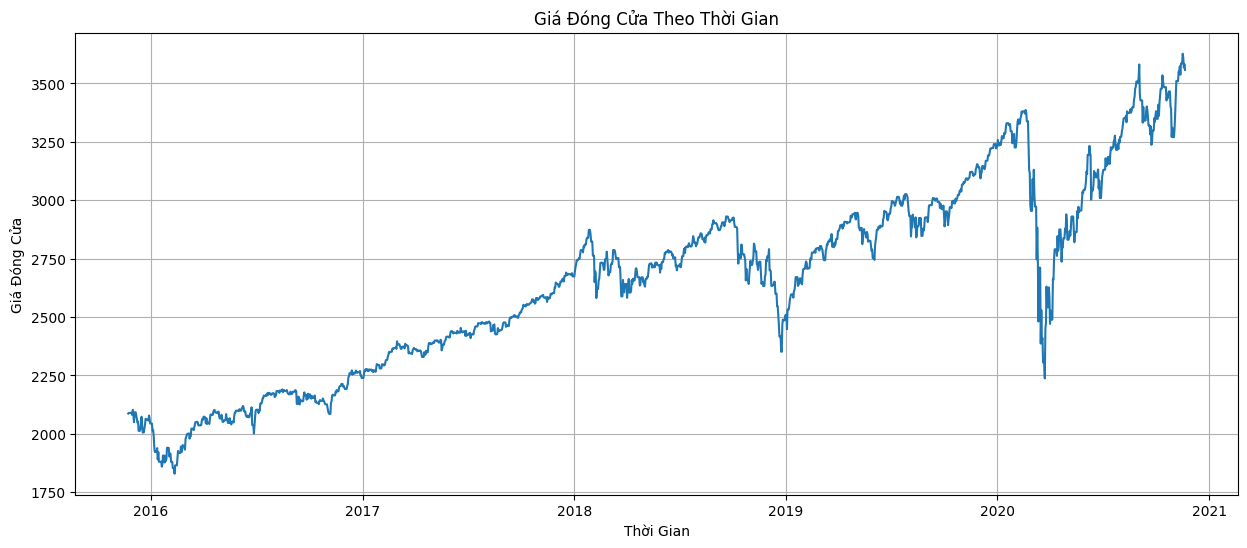

In [9]:
# Vẽ biểu đồ giá đóng cửa theo thời gian
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'])
plt.title('Giá Đóng Cửa Theo Thời Gian')
plt.xlabel('Thời Gian')
plt.ylabel('Giá Đóng Cửa')
plt.grid(True)
plt.show()


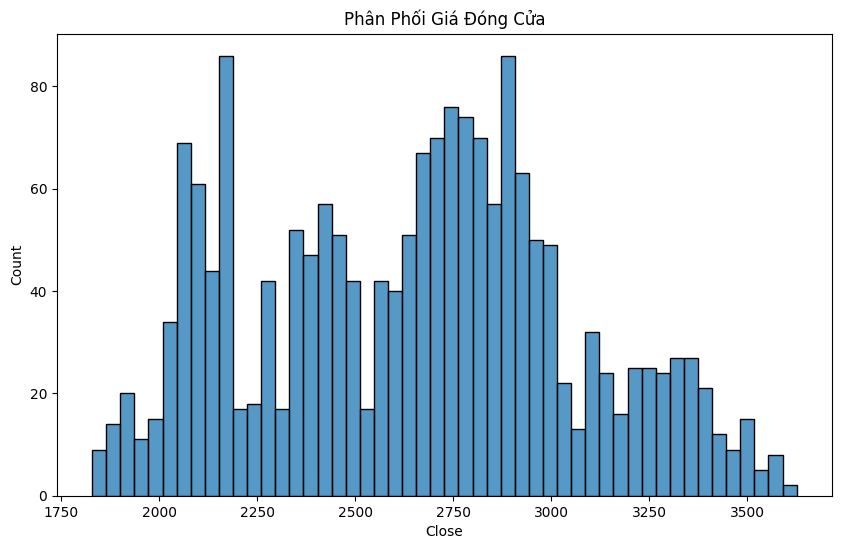

In [12]:
# Vẽ biểu đồ phân phối giá đóng cửa
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], bins=50)
plt.title('Phân Phối Giá Đóng Cửa')
plt.show()

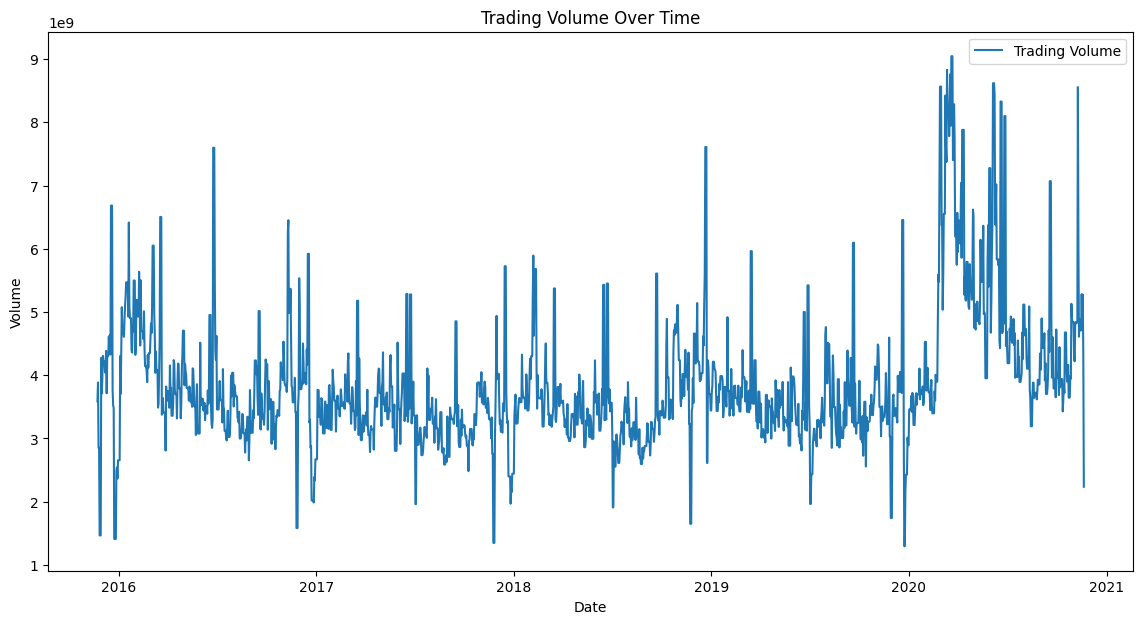

In [13]:
plt.figure(figsize=(14,7))
plt.plot(df['Volume'], label='Trading Volume')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

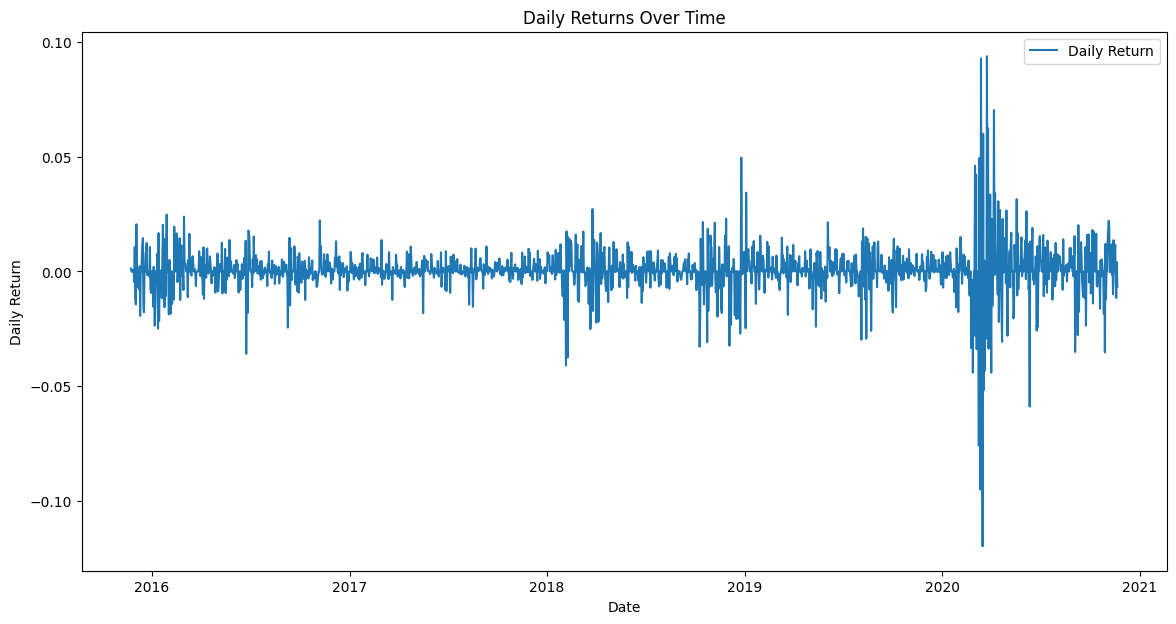

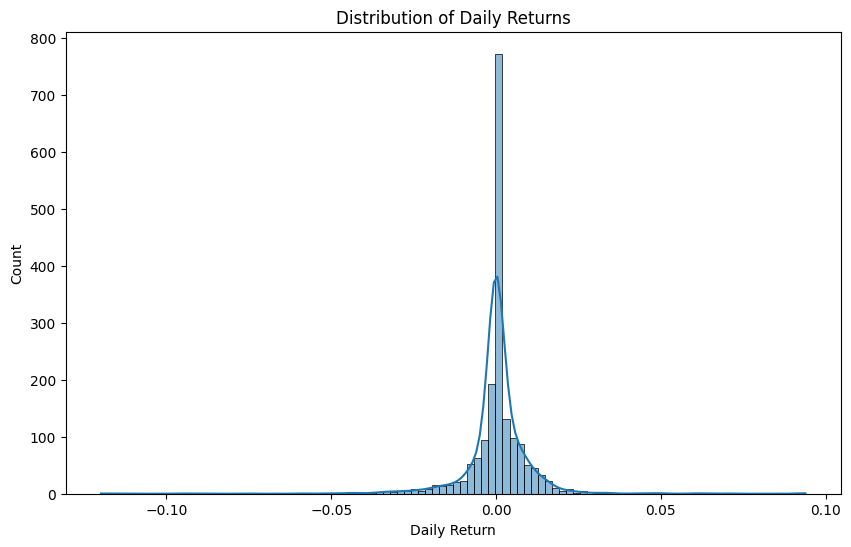

In [14]:
import seaborn as sns

df['Daily Return'] = df['Close'].pct_change()
plt.figure(figsize=(14,7))
plt.plot(df['Daily Return'], label='Daily Return')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df['Daily Return'].dropna(), bins=100, kde=True)
plt.title('Distribution of Daily Returns')
plt.show()

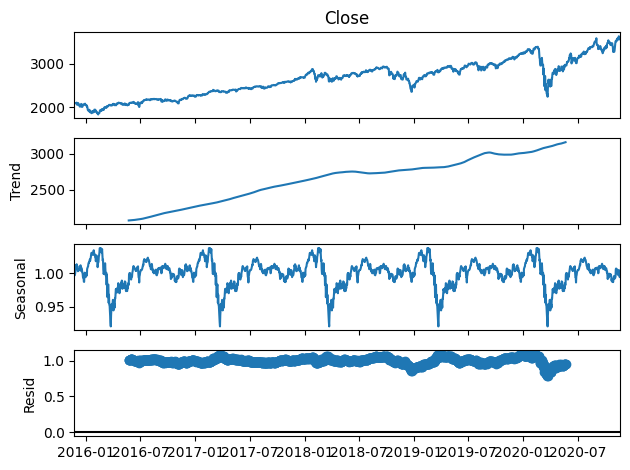

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Close'], model ='multiplicative', period = 365)
result.plot()
plt.show()

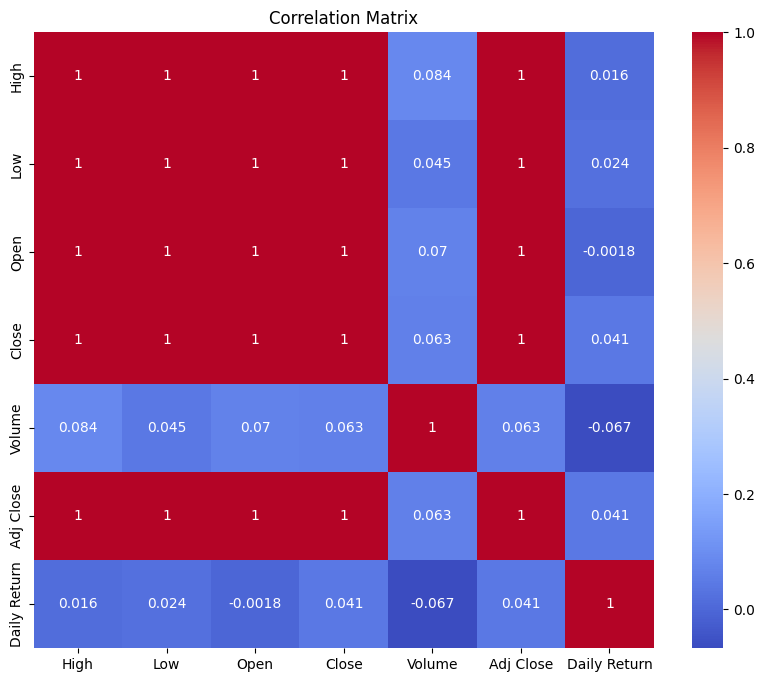

In [16]:
corr_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Build all model (LSTM,GRU)

In [17]:
def prepare_data(data, look_back=60):
    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[['Close']])
    
    # Tạo chuỗi thời gian
    X, y = [], []
    for i in range(len(scaled_data) - look_back):
        X.append(scaled_data[i:(i + look_back)])
        y.append(scaled_data[i + look_back])
    X, y = np.array(X), np.array(y)
    
    # Chia tập dữ liệu
    train_size = int(len(X) * 0.8)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler

# Chuẩn bị dữ liệu
X_train, X_test, y_train, y_test, scaler = prepare_data(df)

In [18]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model(input_shape):
    model = Sequential([
        GRU(50, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        GRU(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = inputs
    
    # Transformer block
    x = MultiHeadAttention(key_dim=256, num_heads=4)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [21]:
# Lấy input_shape từ dữ liệu đã chuẩn bị
input_shape = (X_train.shape[1], 1)
print("Input shape:", input_shape)

# Khởi tạo các mô hình
lstm_model = build_lstm_model(input_shape)
gru_model = build_gru_model(input_shape)
cnn_lstm_model = build_cnn_lstm_model(input_shape)
transformer_model = build_transformer_model(input_shape)

# In ra cấu trúc của các mô hình để kiểm tra
print("\nCấu trúc mô hình LSTM:")
lstm_model.summary()

print("\nCấu trúc mô hình GRU:")
gru_model.summary()

print("\nCấu trúc mô hình CNN-LSTM:")
cnn_lstm_model.summary()

print("\nCấu trúc mô hình Transformer:")
transformer_model.summary()

Input shape: (60, 1)

Cấu trúc mô hình LSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


Cấu trúc mô hình GRU:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)


Cấu trúc mô hình CNN-LSTM:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 27, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 13, 50)         │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,283 (169.07 KB)

 Trainable params: 43,283 (169.07 KB)

 Non-trainable params: 0 (0.00 B)


Cấu trúc mô hình Transformer:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 1)     │      7,169 │ input_layer_3[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 1)     │          2 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 50)        │        100 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 50)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         51 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,322 (28.60 KB)

 Trainable params: 7,322 (28.60 KB)

 Non-trainable params: 0 (0.00 B)


Đang huấn luyện mô hình LSTM...
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0627 - val_loss: 6.8397e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0061 - val_loss: 9.9929e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0029 - val_loss: 6.0207e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0026 - val_loss: 5.9303e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0028 - val_loss: 7.9803e-04
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0027 - val_loss: 9.1002e-04
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0024 - val_loss: 8.0102e-04
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0027 - val_loss: 7.5923e-0

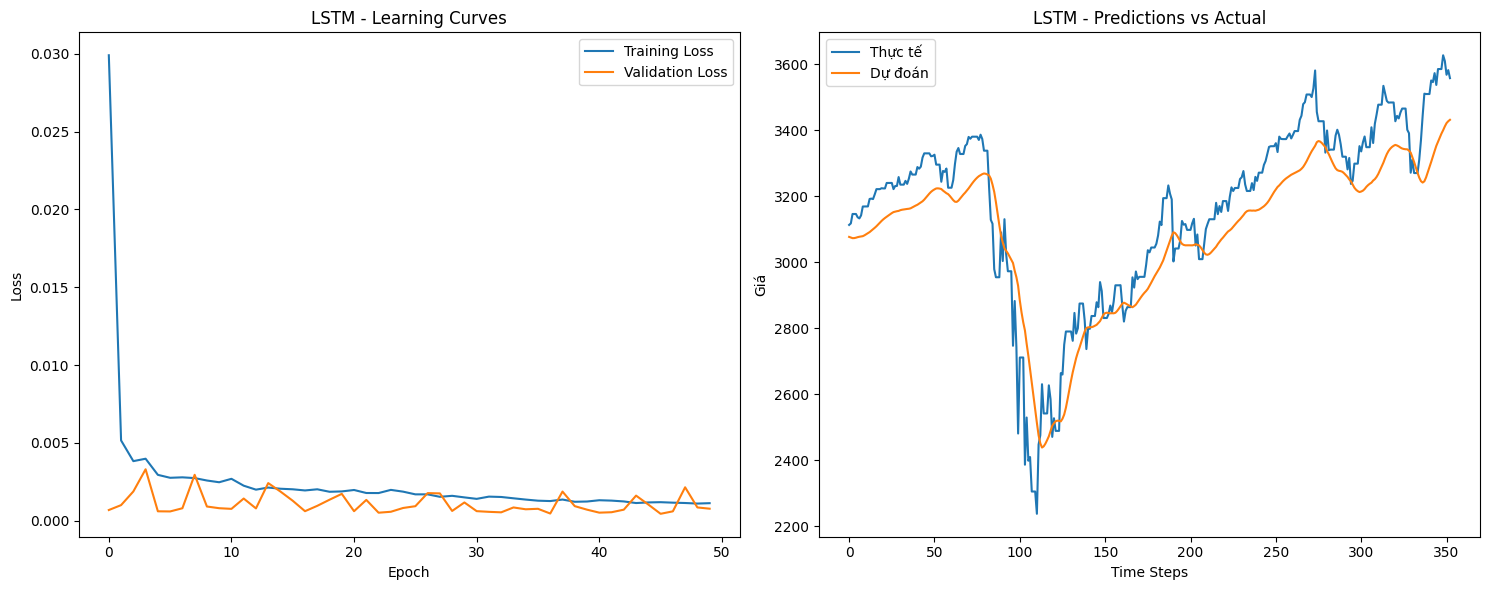


Đang huấn luyện mô hình GRU...
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.1128 - val_loss: 0.0295
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0081 - val_loss: 6.2468e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0033 - val_loss: 9.1596e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0027 - val_loss: 9.5838e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0026 - val_loss: 9.4429e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0029 - val_loss: 8.3190e-04
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0021 - val_loss: 5.7244e-04
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0022 - val_loss: 4.0247e-04
Epo

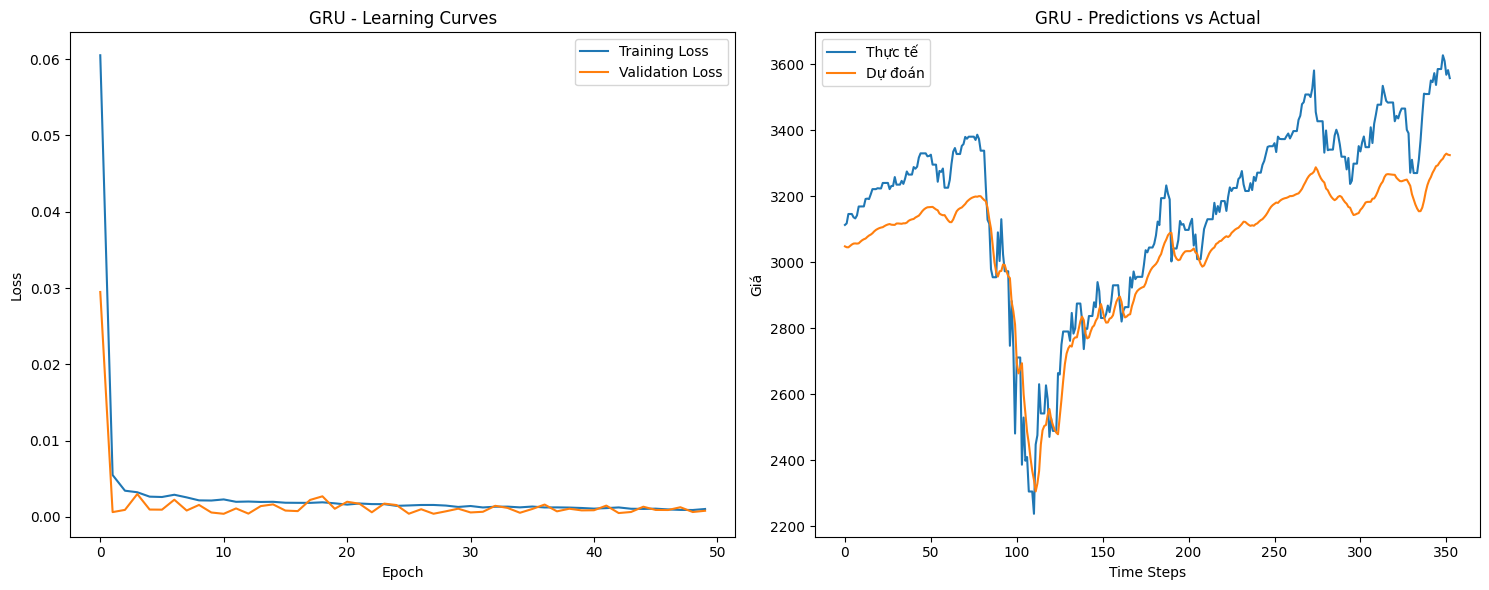


Đang huấn luyện mô hình CNN-LSTM...
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0682 - mae: 0.1976 - val_loss: 0.0069 - val_mae: 0.0746
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - mae: 0.0431 - val_loss: 0.0016 - val_mae: 0.0348
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0412 - val_loss: 0.0028 - val_mae: 0.0459
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0397 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0030 - mae: 0.0403 - val_loss: 0.0015 - val_mae: 0.0344
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - mae: 0.0372 - val_loss: 0.0026 - val_mae: 0.0447
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - mae: 0.0379 - val_loss: 0.0016 - val_mae: 0.0357
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - mae: 0.0398 - val_loss: 0.0022 - val_mae: 0.0413
Epoch 9/50
40/40 ━━━━━━━━━━

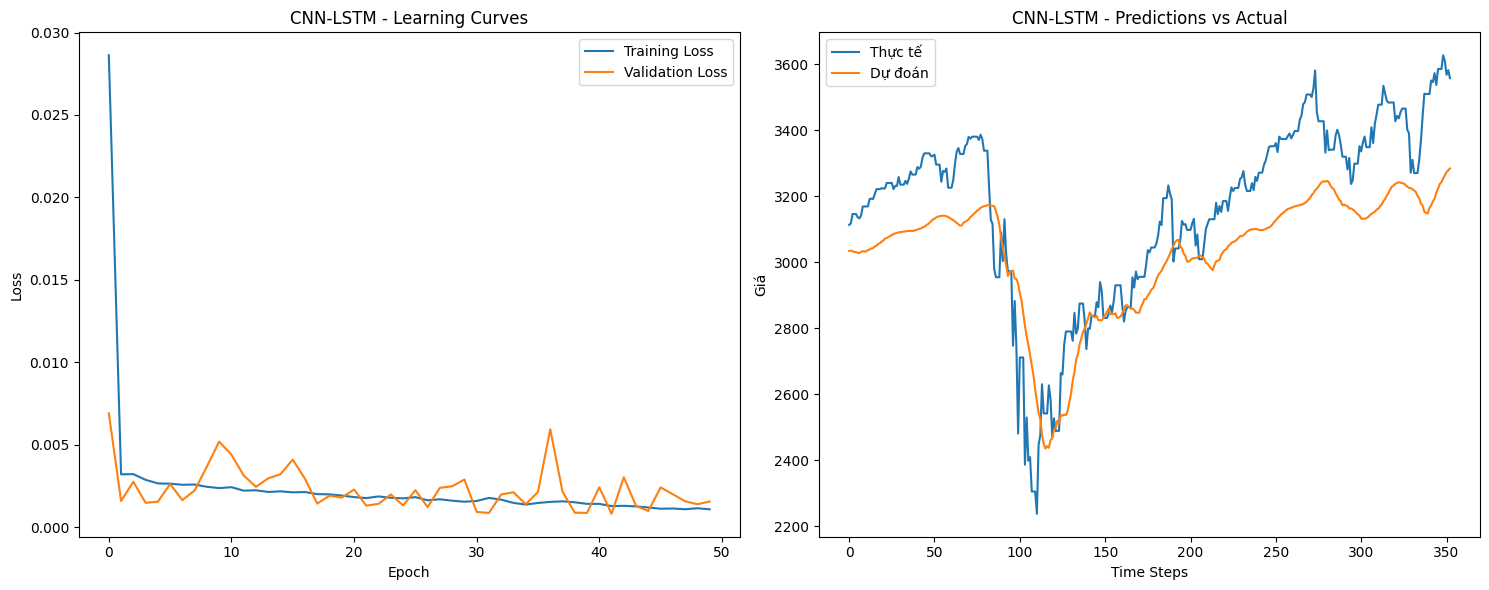


Đang huấn luyện mô hình Transformer...
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.1585 - mae: 0.3629 - val_loss: 0.3721 - val_mae: 0.6085
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1334 - mae: 0.3271 - val_loss: 0.3278 - val_mae: 0.5709
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1069 - mae: 0.2873 - val_loss: 0.2893 - val_mae: 0.5361
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0893 - mae: 0.2546 - val_loss: 0.2555 - val_mae: 0.5036
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0738 - mae: 0.2279 - val_loss: 0.2258 - val_mae: 0.4732
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0633 - mae: 0.2110 - val_loss: 0.2004 - val_mae: 0.4456
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0501 - mae: 0.1856 - val_loss: 0.1790 - val_mae: 0.4209
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0431 - mae: 0.1743 - val_loss: 0.1604 - val_mae: 0.3982
Epoch 9/50
40/40 ━━━━━━━

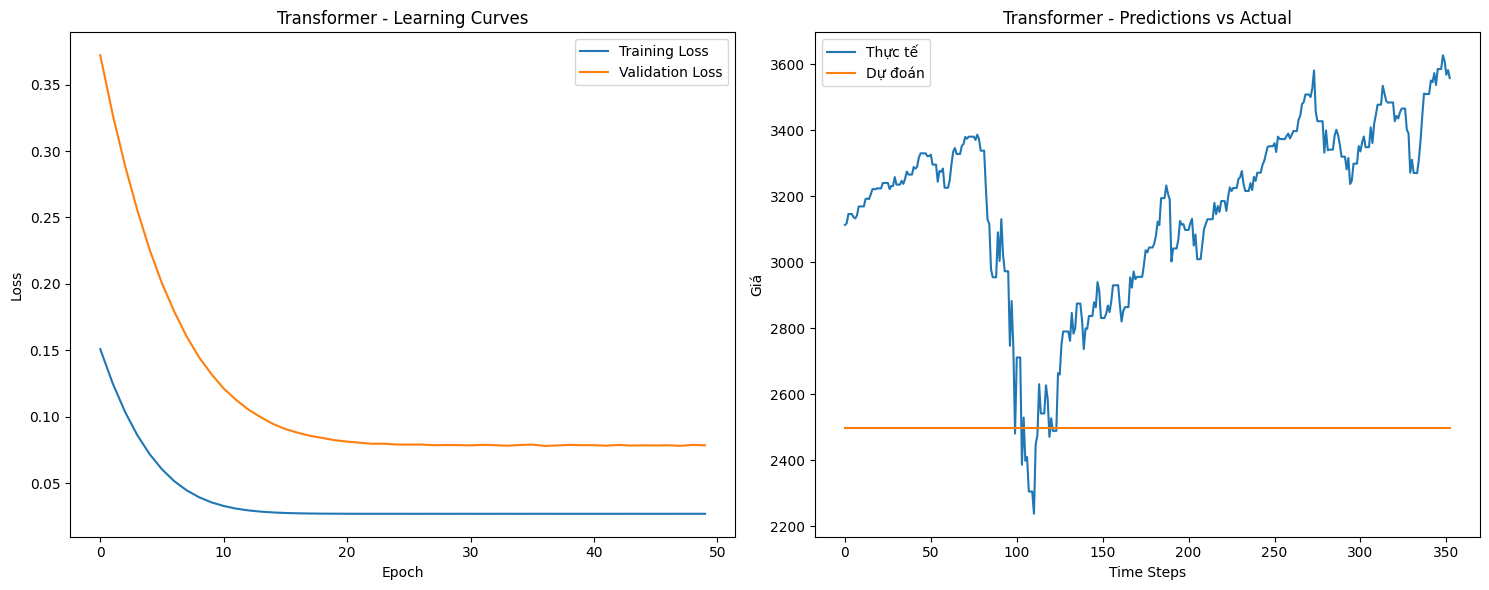

In [22]:
# Tạo dictionary chứa các mô hình
models = {
    'LSTM': lstm_model,
    'GRU': gru_model,
    'CNN-LSTM': cnn_lstm_model,
    'Transformer': transformer_model
}

# Dictionary để lưu kết quả
results = {}
predictions = {}

# Huấn luyện và đánh giá từng mô hình
for name, model in models.items():
    print(f'\nĐang huấn luyện mô hình {name}...')
    
    # Huấn luyện mô hình
    history = model.fit(X_train, y_train,
                       epochs=50,
                       batch_size=32,
                       validation_split=0.1,
                       verbose=1)
    
    # Dự đoán
    y_pred = model.predict(X_test)
    
    # Chuyển đổi về giá gốc
    y_test_inv = scaler.inverse_transform(y_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    # Tính các metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)
    
    # In kết quả
    print(f'\nKết quả đánh giá mô hình {name}:')
    print(f'RMSE: {rmse:.2f}')
    print(f'R2 Score: {r2:.4f}')
    
    # Lưu kết quả
    predictions[name] = y_pred_inv
    results[name] = {
        'rmse': rmse,
        'r2': r2,
        'history': history.history
    }
    
    # Vẽ biểu đồ learning curves và predictions
    plt.figure(figsize=(15, 6))
    
    # Learning curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Predictions vs Actual
    plt.subplot(1, 2, 2)
    plt.plot(y_test_inv, label='Thực tế')
    plt.plot(y_pred_inv, label='Dự đoán')
    plt.title(f'{name} - Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Giá')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Evaluate and Predict

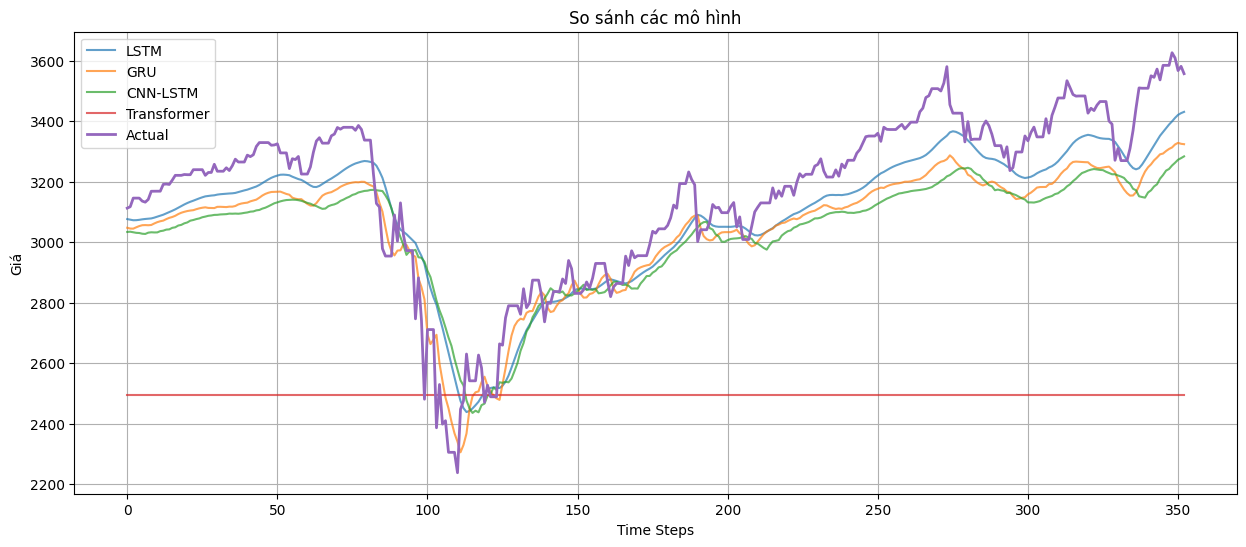


Bảng so sánh các mô hình:
         Model        RMSE  R2 Score
0         LSTM  125.151128  0.795826
1          GRU  149.763961  0.707621
2     CNN-LSTM  186.573780  0.546233
3  Transformer  721.399103 -5.783952


In [23]:
# Vẽ biểu đồ so sánh tất cả các mô hình
plt.figure(figsize=(15, 6))
for name, pred in predictions.items():
    plt.plot(pred, label=name, alpha=0.7)
plt.plot(scaler.inverse_transform(y_test), label='Actual', linewidth=2)
plt.title('So sánh các mô hình')
plt.xlabel('Time Steps')
plt.ylabel('Giá')
plt.legend()
plt.grid(True)
plt.show()

# Tạo bảng so sánh các metrics
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[model]['rmse'] for model in results],
    'R2 Score': [results[model]['r2'] for model in results]
})

print("\nBảng so sánh các mô hình:")
print(comparison_df)

In [ ]:
def hybrid_predict(lstm_pred, gru_pred, weight_lstm=0.5):
    return weight_lstm * lstm_pred + (1 - weight_lstm) * gru_pred

def predict_future(model, last_sequence, n_steps, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        next_pred = model.predict(current_sequence.reshape(1, 60, 1))
        future_predictions.append(next_pred[0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
    
    return scaler.inverse_transform(np.array(future_predictions))

# Kết hợp dự đoán
hybrid_predictions = hybrid_predict(lstm_pred, gru_pred)

# Dự đoán 30 ngày tiếp theo
future_days = 30
last_sequence = X_test[-1]
future_pred_lstm = predict_future(lstm_model, last_sequence, future_days, scaler)
future_pred_gru = predict_future(gru_model, last_sequence, future_days, scaler)
future_pred_hybrid = hybrid_predict(future_pred_lstm, future_pred_gru)

# Vẽ biểu đồ dự đoán tương lai
plt.figure(figsize=(15, 6))
plt.plot(df.index[-100:], df['Close'].values[-100:], label='Lịch sử')
plt.plot(pd.date_range(start=df.index[-1], periods=future_days+1)[1:], 
         future_pred_hybrid, label='Dự đoán')
plt.title('Dự Đoán Giá Cổ Phiếu 30 Ngày Tiếp Theo')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend()
plt.show()